In [189]:
# %load heptrx_nnconv_test.py
import os
import os.path as osp
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets.hitgraphs import HitGraphDataset
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import (NNConv, graclus, max_pool, max_pool_x,
                                global_mean_pool)
import tqdm
import argparse

from models.gnn_geometric import GNNSegmentClassifier as Net
from models.EdgeNet import EdgeNet

from heptrx_nnconv import test

from datasets.graph import draw_sample

import awkward
import matplotlib.pyplot as plt
import scipy.stats as stats

batch_size = 1
hidden_dim = 64
n_iters = 12

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device %s'%device)

    
directed = False
path = osp.join(os.environ['GNN_TRAINING_DATA_ROOT'], 'single_mu')
full_dataset = HitGraphDataset(path, directed=directed)
fulllen = len(full_dataset)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
    
#test_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=0,stop=256))
test_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=splits[0],stop=splits[1]))

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
test_samples = len(test_dataset)

d = full_dataset
num_features = d.num_features
num_classes = d[0].y.max().item() + 1 if d[0].y.dim() == 1 else d[0].y.size(1)
    
model = EdgeNet(input_dim=num_features,hidden_dim=hidden_dim,n_iters=n_iters).to(device)
model_fname = "../checkpoints/model_checkpoint_EdgeNet_13579_5946285673_liumy871227.best.pth.tar"
print('Model: \n%s\nParameters: %i' %
          (model, sum(p.numel()
                      for p in model.parameters())))
print('Testing with %s samples'%test_samples)
model.load_state_dict(torch.load(model_fname)['model'])

test_loss, test_acc, test_eff, test_fp, test_fn, test_pur = test(model, test_loader, test_samples)
print('Testing: Loss: {:.4f}, Eff.: {:.4f}, FalsePos: {:.4f}, FalseNeg: {:.4f}, Purity: {:,.4f}'.format(test_loss, test_eff,
                                                                                                            test_fp, test_fn, test_pur))

# plotting:
figs = []
t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
out = []
y = []
x = []
edge_index = []
simmatched = []
for i,data in t:
    data = data.to(device)
    #print(data)
    out.append(model(data).cpu().detach().numpy())
    x.append(data.x.cpu().detach().numpy())
    y.append(data.y.cpu().detach().numpy())
    edge_index.append(data.edge_index.cpu().detach().numpy())
out = awkward.fromiter(out)
x = awkward.fromiter(x)
y = awkward.fromiter(y)
edge_index = awkward.fromiter(edge_index)

using device cuda


batch loss = 1.43113:   2%|▏         | 14/872.0625 [00:00<00:06, 133.37it/s]

Model: 
EdgeNet(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=138, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (nodenetwork): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
  ))
)
Parameters: 13579
Testing with 27906 samples


batch loss = 0.54883: : 27906it [03:34, 130.05it/s]                          
  0%|          | 19/27906.0 [00:00<02:34, 180.37it/s]

scor 475765 stru 193218.0 stp 165012 stn 310753 sfp 54917 sfn 28206 stot 558888
Testing: Loss: 0.3693, Eff.: 0.8540, FalsePos: 0.1502, FalseNeg: 0.1460, Purity: 0.7503


100%|██████████| 27906/27906.0 [02:31<00:00, 183.92it/s]


predicted connected nodes [[0 1] [1 2 3 ... 10 11 12] [0 1 3 5 9] ... [0 1 2 ... 6 9 10] [1 2 3 4 8] [1 2 3 7 9]]


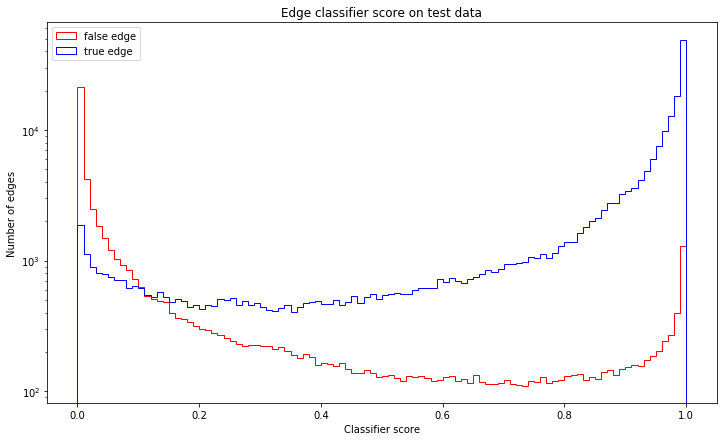

In [158]:
cut = 0.15
predicted_edge = (out > cut)
true_edge = (y > 0.5)
fake_edge = (y < 0.5)
true_edge_score = out[true_edge]
fake_edge_score = out[fake_edge]
predicted_connected_node_indices = awkward.JaggedArray.concatenate([edge_index[:,0][predicted_edge], edge_index[:,1][predicted_edge]], axis=1)
predicted_connected_node_indices = awkward.fromiter(map(np.unique, predicted_connected_node_indices))
true_connected_node_indices = awkward.JaggedArray.concatenate([edge_index[:,0][true_edge],edge_index[:,1][true_edge]], axis=1)
true_connected_node_indices = awkward.fromiter(map(np.unique, true_connected_node_indices))

print("predicted connected nodes",predicted_connected_node_indices)
    #def buildtracks(edges):
        #   return tracks
    #factorize the plotting part
fig,axes = plt.subplots(figsize=(12, 7))
_, bins,_ = axes.hist([true_edge_score.flatten(),fake_edge_score.flatten()],weights=[[1]*len(true_edge_score.flatten()),[0.15]*len(fake_edge_score.flatten())], bins=100,color=['b','r'],label=['true edge','false edge'],histtype='step',fill=False)

plt.title("Edge classifier score on test data")
plt.ylabel("Number of edges")
plt.xlabel("Classifier score")
plt.legend(loc='upper left')
plt.yscale('log')
figs.append(fig)
    
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("test_plots.pdf")
for fig in figs: 
    pdf.savefig(fig)
pdf.close()

In [188]:
print(out)

[[0.9803233 0.98041546] [0.025363727 0.32036775 0.056898136 ... 0.013436312 0.7824131 0.9792597] [0.9496521 0.26353005 0.97724026 ... 0.115334734 0.049834516 9.682617e-05] ... [0.021852039 0.026402533 0.5527084 ... 0.9981944 0.9996351 0.99435943] [0.09775389 0.08870763 0.04241463 ... 0.8442825 0.70586014 0.05258188] [0.09713066 0.25704545 0.06899177 ... 0.00018160917 0.0007078308 0.9286401]]


In [159]:
print(edge_index[:,0])
print(edge_index[:,1])

predicted_node_average = [len(x[predicted_connected_node_indices][i]) for i in range(len(x))]
true_node_average = [len(x[true_connected_node_indices][i]) for i in range(len(x))]
print(len(x[true_connected_node_indices][1]))

[[0 1] [0 6 6 ... 12 12 2] [5 9 0 ... 7 3 7] ... [8 11 0 ... 1 3 5] [0 7 7 ... 3 4 6] [3 3 4 ... 12 1 2]]
[[1 0] [6 3 8 ... 5 10 1] [0 0 1 ... 1 6 6] ... [0 0 2 ... 6 1 3] [7 1 8 ... 8 2 2] [4 7 9 ... 10 12 1]]
4


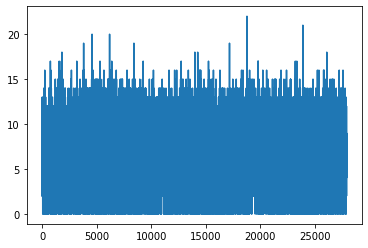

In [160]:
plt.plot(predicted_node_average)

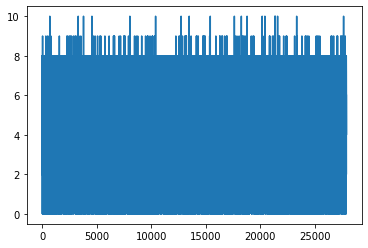

In [161]:
plt.plot(true_node_average)

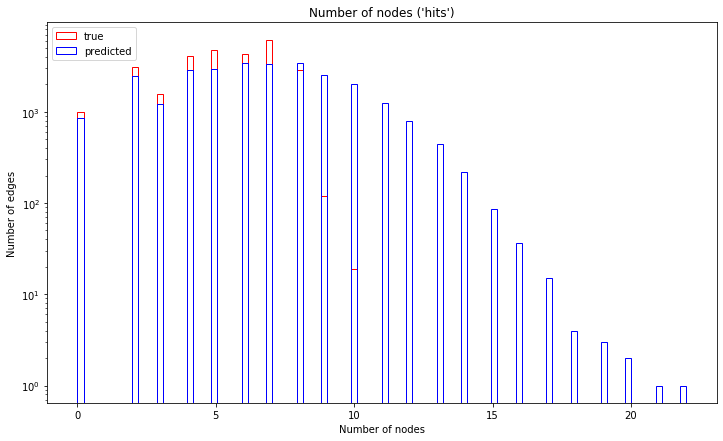

In [168]:
fig,axes = plt.subplots(figsize=(12, 7))
_, bins,_ = axes.hist([predicted_node_average,true_node_average], bins=100,color=['b','r'],label=['predicted','true'],histtype='step',fill=False)
plt.title("Number of nodes ('hits')")
plt.ylabel("Number of edges")
plt.xlabel("Number of nodes")
plt.legend(loc='upper left')
plt.yscale('log')
figs.append(fig)

In [178]:
# looks like many events have fewer than 10 real hits associated with real muon tracks
filtered_indices = [i for i, x in enumerate(predicted_node_average) if x < 11]
predicted_hitlayers = x[predicted_connected_node_indices][:,:,-3]
true_hitlayers=x[true_connected_node_indices][:,:,-3]
print(predicted_hitlayers)
print(true_hitlayers)
len(predicted_hitlayers)

[[10.0 11.0] [10.0 11.0 2.0 ... 7.0 4.0 8.0] [9.0 10.0 11.0 8.0 8.0] ... [1.0 5.0 2.0 ... 4.0 2.0 3.0] [3.0 7.0 4.0 8.0 3.0] [10.0 11.0 2.0 3.0 4.0]]
[[10.0 11.0] [10.0 11.0 2.0 3.0] [9.0 10.0 11.0 8.0] ... [1.0 5.0 2.0 ... 3.0 7.0 4.0] [3.0 7.0 4.0 8.0] [10.0 11.0 2.0 3.0 7.0 8.0]]


27906

In [181]:
x[predicted_connected_node_indices][1,:,-3]

array([10., 11.,  2.,  3.,  1.,  5.,  6.,  7.,  4.,  8.], dtype=float32)